In [1]:
from argparse import Namespace

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import sklearn
import nilearn as nl
from sklearn.manifold import TSNE
import re
from nilearn.input_data import NiftiMasker
from sklearn.cluster import KMeans
import math 
from numpy import dot
from numpy.linalg import norm
import time

/usr/local/lib/python3.10/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
participants = pd.read_csv('/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/train/train_labels/participants.tsv', sep="\t")  
age_gender = participants.loc[:, ["age", "sex"]]
duplicates = participants["participant_id"][participants["participant_id"].isin(participants["participant_id"][participants["participant_id"].duplicated()])]


In [4]:
def loadFileNames(path, type):
    return  glob.glob(os.path.join(path, type))


In [11]:
def laodFiles(files):
    i=0
    sub_info = pd.DataFrame(dtype=float)
    feat_set = np.load(files[0])
    for file in files:
        file_i = np.load(file)
        id = re.search("sub-(.*)_prep", file)
        id = round(int(id.group(1)), -6)
        age = participants["age"].loc[participants['participant_id'] == id]
        age = age.astype(float)
        if id not in duplicates.values:
            sub_info = sub_info.append([[id,age.values]], ignore_index=True)
            feat_set = np.concatenate((feat_set, file_i))
        i = i+1

        if i==1100:
            break
    
    sub_info.iloc[:, 1] = sub_info.iloc[:,1].astype(float)
    return feat_set, sub_info

T-SNE projection of the feature matrix with k-means age clusters

In [33]:
# sub_metadata = pd.read_csv('/media/dataanalyticlab/Drive2/MANSOOR/Dataset/openbhb_sub_metadata_k-means_cluster.csv')
# reduced_train_matrix = pd.read_csv('/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Reduced_matrices_openbhb/openbhb_train_roi_dataset.csv', header=None, usecols=np.arange(1,1797))
reduced_train_matrix = np.load("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Reduced_matrices_openbhb/CAT12_VBM_features_Quasi_Raw_features_PCA_openbhb_train_dataset.npy")
reduced_train_matrix = pd.DataFrame(reduced_train_matrix)


In [14]:
tsne = pd.DataFrame(np.load("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Reduced_matrices_openbhb/reduced_tSNE_openbhb_train_dataset.npy"))

In [34]:
k = 3
# findAgeClusters(sub_metadata, k)
# clusters = findClusterIntervals(sub_metadata , k)
for i in range(50,500, 50):
    tsne = findTSNEcomp(reduced_train_matrix, sub_metadata, perplexity=i, k=3)
    print("Perplexity = ", i)
    fig = PlotTSNE(tsne, k)
    # plt.show()
    
    fig.savefig("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/EDA/tSNE_openbhb/PCA_1000_components/tsne_quasiraw_cat12_1000-pca_"+str(i)+"-perp_"+str(k)+"-clusters.png")
    plt.close(fig)


Perplexity =  50
Perplexity =  100
Perplexity =  150
Perplexity =  200
Perplexity =  250
Perplexity =  300
Perplexity =  350
Perplexity =  400
Perplexity =  450


In [24]:
# plot tsne projection of the tsne components derived already 
tsne_feat = pd.DataFrame()
tsne_feat["Cluster_ID"] = sub_metadata.loc[:, "Cluster_ID(" + str(k)+"-means)"]
tsne_feat["age-cluster"] = sub_metadata.loc[:, "age-interval(" + str(k)+"-means)"]
tsne_feat["Age"] = sub_metadata.iloc[:, 2]
tsne_feat["comp-1"] = tsne.iloc[:,0]
tsne_feat["comp-2"] = tsne.iloc[:,1]
fig = PlotTSNE(tsne_feat,4)
fig.savefig("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/EDA/tSNE_openbhb/PCA_1000_components/tsne_reduced_"+str(i)+"-perp_"+str(k)+"-clusters.png")
plt.close(fig)


In [92]:
def findAgeClusters(sub_info, k):
    kmeans = KMeans(k)
    ages = np.array(sub_info.iloc[:,1])
    ages = ages.reshape(ages.shape[0],-1)
    clusters = kmeans.fit_predict(ages)
    sub_info["Cluster_ID("+str(k)+ "-means)"] = clusters

In [104]:
def findClusterIntervals(sub_info, k):
    intervals = sub_info.groupby("Cluster_ID("+str(k)+ "-means)").agg(Min_Age=(1, 'min'),
    Max_Age=(1, 'max'),Mean_Age=(1, 'mean'), Frequency=(1,"count")).reset_index()
    intervals.iloc[:,:3] = round(intervals.iloc[:,:3], 2).astype(int)
    mapping = {0: str(intervals.iloc[0,1]) + " - " + str(intervals.iloc[0,2]), 
    1: str(intervals.iloc[1,1]) + " - " + str(intervals.iloc[1,2]),
    2: str(intervals.iloc[2,1]) + " - " + str(intervals.iloc[2,2]),
    3: str(intervals.iloc[3,1]) + " - " + str(intervals.iloc[3,2]),
    4: str(intervals.iloc[4,1]) + " - " + str(intervals.iloc[4,2]),
    5: str(intervals.iloc[5,1]) + " - " + str(intervals.iloc[5,2]),
    6: str(intervals.iloc[6,1]) + " - " + str(intervals.iloc[6,2]),
    7: str(intervals.iloc[7,1]) + " - " + str(intervals.iloc[7,2])
    }
    cluster = [mapping[i] for i in sub_info["Cluster_ID("+str(k)+ "-means)"]]
    sub_info["age-interval("+str(k)+ "-means)"] = cluster
    return intervals
    
    

In [22]:
def findTSNEcomp(features, sub_info, perplexity, k):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsne = tsne.fit_transform(features)
    tsne_feat = pd.DataFrame()
    tsne_feat["Cluster_ID"] = sub_metadata.loc[:, "Cluster_ID(" + str(k)+"-means)"]
    tsne_feat["age-cluster"] = sub_metadata.loc[:, "age-interval(" + str(k)+"-means)"]
    tsne_feat["Age"] = sub_metadata.iloc[:, 2].astype(int)
    tsne_feat["comp-1"] = tsne[:,0]
    tsne_feat["comp-2"] = tsne[:,1]
    return tsne_feat
     

In [5]:
def PlotTSNE(tsne, k):
    tsne_sort = tsne.sort_values(by="Age")
    fig = plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=tsne_sort.loc[:, "age-cluster"],
     color=["r", "g", "b", "y"], palette=sns.color_palette("hls", k), 
                data=tsne_sort.loc[:, ["comp-1", "comp-2"]])
    return fig


In [5]:
path = '/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/train/train_fsl/'
files = loadFileNames(path, "*xhemi_T1w.npy")
# features, subjects = laodFiles(files)
# feature_set = pd.DataFrame(features.reshape(features.shape[0],-1)).iloc[1:,:]
# subjects_subset1 = subjects
# tsne = TSNE(n_components=2, perplexity=7)
# tsne_subset1 = tsne.fit_transform(feature_set)
# findAgeClusters(5,subjects)
# clusters = findClusterIntervals(subjects)
# tsne = findTSNEcomp(feature_set, subjects)
# PlotTSNE(tsne, 5)

Age gender distribution 

In [ ]:
train_subjects = pd.read_csv("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/openbhb_sub_metadata.csv", delimiter=",", header=None,  usecols=[1,2])
val_subjects = pd.read_csv("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/val_participants_openbhb.tsv", delimiter="\t",  usecols=[2,3])
train_subjects = train_subjects.rename(columns={"1":"age", "2":"sex"})
val_subjects = pd.DataFrame({"1":val_subjects.age, "2":val_subjects.sex})

train_subjects.reset_index(drop=True, inplace=True)
val_subjects.reset_index(drop=True, inplace=True)

train_subjects.iloc[:,1] = train_subjects.iloc[:,1].str.rstrip("'")
train_subjects.iloc[:,1] = train_subjects.iloc[:,1].str.lstrip("'")

age = train_subjects.iloc[:,0].append(val_subjects.iloc[:756,0])
sex = train_subjects.iloc[:,1].append(val_subjects.iloc[:756,1])
all_subjects = pd.DataFrame({"age": age, "sex":sex})
all_subjects.reset_index(drop=True, inplace=True)

/tmp/ipykernel_395808/641479498.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  age = train_subjects.iloc[:,0].append(val_subjects.iloc[:756,0])
/tmp/ipykernel_395808/641479498.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sex = train_subjects.iloc[:,1].append(val_subjects.iloc[:756,1])


In [ ]:
print(all_subjects.groupby("sex").count())
print("Mean: ", val_subjects.iloc[:756,0].mean(), "std: ", val_subjects.iloc[:756,0].std())

print("Mean: ", train_subjects.iloc[:,0].mean(), "std: ", train_subjects.iloc[:,0].std())

print(train_subjects.groupby(train_subjects.iloc[:,1]).count())
print(val_subjects.groupby(val_subjects.iloc[:756,1]).count())




         age  Age-bins  Freedman_bins
sex                                  
female  1886      1886           1886
male    2079      2079           2079
Mean:  23.797623946288354 std:  12.76591729498599
Mean:  25.17754470676223 std:  14.585855159577697
           1     2
2                 
female  1548  1548
male    1661  1661
          1    2
2               
female  338  338
male    418  418


24.91443749492913 14.265566608360391


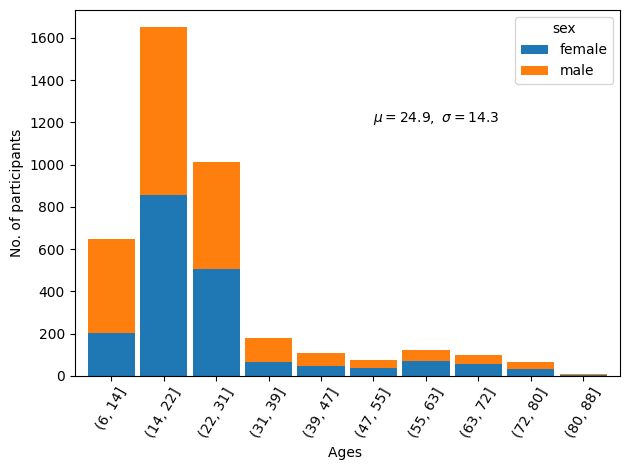

In [ ]:

all_subjects["Age-bins"] = pd.cut(x=all_subjects["age"], bins=10)

all_subjects["Age-bins"] = all_subjects["Age-bins"].apply(lambda x: pd.Interval(left=int(round(x.left)), right=int(round(x.right))))

plot_age_p = all_subjects.pivot_table("age", index="Age-bins", columns="sex", aggfunc='count', fill_value=0)
plot_age_p

print(all_subjects["age"].mean(), all_subjects["age"].std())

plot_age_p.plot(kind="bar", stacked=True, width=0.9)
plt.xticks(rotation = 60)


plt.xlabel("Ages ")
plt.ylabel("No. of participants")
plt.tight_layout()
plt.text(5, 1200, r'$\mu=24.9,\ \sigma=14.3$')
plt.savefig("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/EDA/Age_gender_plots/age_sex_hist_openbhb.png")
plt.show()

In [ ]:
all_subjects.to_csv("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/Participants_summary_stats/All_subjects_metadata.csv")

In [ ]:
from scipy import stats
iqr_age = stats.iqr(all_subjects.iloc[:,0], rng=[25,75], scale="raw", nan_policy="omit")
print("IQR (age): ", iqr_age)
avg_age = all_subjects.age.mean()
std_age = all_subjects.age.std()
print("Mean age: ", avg_age)
print("Std age: ", std_age)
print("Min age: ", all_subjects.iloc[:,0].min())

IQR (age):  7.0
Mean age:  24.91443749492913
Std age:  14.265566608360391
Min age:  5.9


/home/dataanalyticlab/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:3174: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


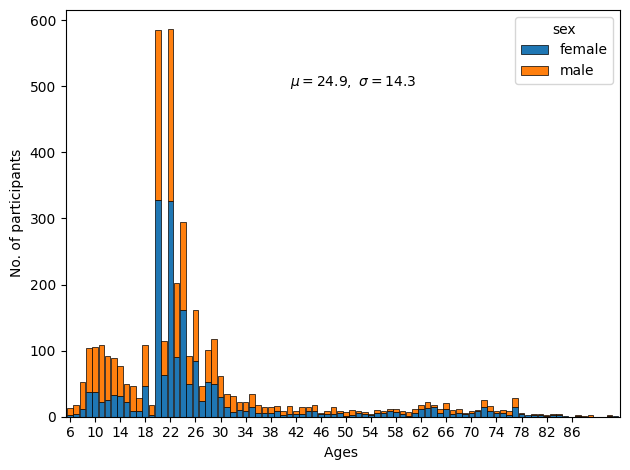

In [ ]:
all_subjects["Freedman_bins"] = pd.cut(x=all_subjects["age"], bins=88)

all_subjects["Freedman_bins"] = all_subjects["Freedman_bins"].apply(lambda x: pd.Interval(left=int(round(x.left)), right=int(round(x.right))))

plot_age_freedman = all_subjects.pivot_table("age", index="Freedman_bins", columns="sex", aggfunc='count', fill_value=0)


plot_age_freedman.plot(kind="bar", stacked=True, width=0.9, edgecolor="black", linewidth=0.5)
x = np.arange(start=6,stop=90, step=4)
# plt.xticks(x)

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0,84, step=4), np.arange(6,90,step=4), rotation=None )  # Set label locations.

plt.xlabel("Ages ")

plt.ylabel("No. of participants")
plt.tight_layout()
plt.text(35, 500, r'$\mu=24.9,\ \sigma=14.3$')
plt.savefig("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/EDA/Age_gender_plots/age_sex_hist_freidman_openbhb.png")
plt.show()

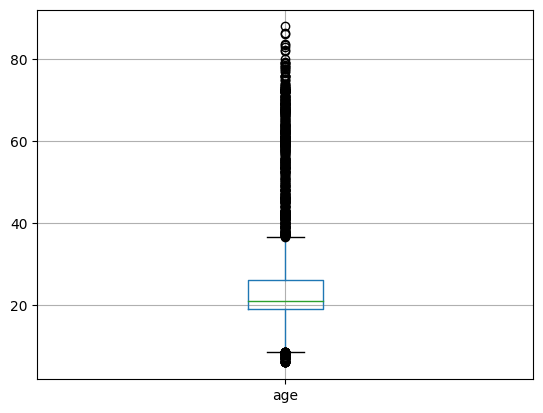

In [ ]:
all_subjects.boxplot(column="age")
plt.savefig("/media/dataanalyticlab/Drive2/MANSOOR/Dataset/OpenBHB/EDA/Age_gender_plots/box_plot_openbhb.png")
plt.show()